In [1]:
import torch.nn as nn
import torch 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

# NN Classification (Perceptron) : gender

## Data preparation

### Load data: NOUN, ADJ, and both

In [2]:
df_nouns_we = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv').drop(columns=["number"])
df_adj_we = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv').drop(columns = "number")
df_both_we = pd.concat([df_nouns_we, df_adj_we], ignore_index=True)

# target : gender
Y_gd_N = df_nouns_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)
Y_gd_A = df_adj_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)
Y_gd_both = df_both_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)

# features : word embeddings dimensions
X_gd_N = df_nouns_we.drop(columns=["Word", "gender"])
X_gd_A = df_adj_we.drop(columns=["Word", "gender"])
X_gd_both = df_both_we.drop(columns = ["Word", "gender"] )

# normalize data to be between 0 and 1
X_gd_N = (X_gd_N - X_gd_N.min()) / (X_gd_N.max() - X_gd_N.min())
X_gd_A = (X_gd_A - X_gd_A.min()) / (X_gd_A.max() - X_gd_A.min())
X_gd_both = (X_gd_both - X_gd_both.min()) / (X_gd_both.max() - X_gd_both.min())

# split data into train and test sets
X_gd_N_train, X_gd_N_test, Y_gd_N_train, Y_gd_N_test = train_test_split(X_gd_N, Y_gd_N, test_size=0.2, random_state=42)
X_gd_A_train, X_gd_A_test, Y_gd_A_train, Y_gd_A_test = train_test_split(X_gd_A, Y_gd_A, test_size=0.2, random_state=42)
X_gd_both_train, X_gd_both_test, Y_gd_both_train, Y_gd_both_test = train_test_split(X_gd_both, Y_gd_both, test_size=0.2, random_state=42)

In [3]:
# print all the shapes
print("X_gd_N_train shape : ", X_gd_N_train.shape)
print("X_gd_N_test shape : ", X_gd_N_test.shape)
print("Y_gd_N_train shape : ", Y_gd_N_train.shape)
print("Y_gd_N_test shape : ", Y_gd_N_test.shape)
print("X_gd_A_train shape : ", X_gd_A_train.shape)
print("X_gd_A_test shape : ", X_gd_A_test.shape)
print("Y_gd_A_train shape : ", Y_gd_A_train.shape)
print("Y_gd_A_test shape : ", Y_gd_A_test.shape)
print("X_gd_both_train shape : ", X_gd_both_train.shape)
print("X_gd_both_test shape : ", X_gd_both_test.shape)

X_gd_N_train shape :  (10590, 512)
X_gd_N_test shape :  (2648, 512)
Y_gd_N_train shape :  (10590,)
Y_gd_N_test shape :  (2648,)
X_gd_A_train shape :  (5067, 512)
X_gd_A_test shape :  (1267, 512)
Y_gd_A_train shape :  (5067,)
Y_gd_A_test shape :  (1267,)
X_gd_both_train shape :  (15657, 512)
X_gd_both_test shape :  (3915, 512)


In [4]:
train_features = [X_gd_N_train, X_gd_A_train, X_gd_both_train]
test_features = [X_gd_N_test, X_gd_A_test, X_gd_both_test]
train_targets = [Y_gd_N_train, Y_gd_A_train, Y_gd_both_train]
test_targets = [Y_gd_N_test, Y_gd_A_test, Y_gd_both_test]

### Tensors

In [5]:
# convert to tensors
train_features = [torch.tensor(x.values).float() for x in train_features]
test_features = [torch.tensor(x.values).float() for x in test_features]
train_targets = [torch.tensor(x.values).long() for x in train_targets]
test_targets = [torch.tensor(x.values).long() for x in test_targets]

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_features, train_targets)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_features, test_targets)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

## Classification

### NN definition

In [7]:
NNlist = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer 
    model = nn.Sequential(nn.Linear(512, 1), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist.append([model, loss_fn, optimizer])

## Train the models

In [8]:
nb_epochs = 100

In [9]:
# train the models 
for i in range(3):
    print("* Training model ", i)
    model, loss_fn, optimizer = NNlist[i]
    # put the model in training mode
    model.train()
    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  0


IndexError: Target 1 is out of bounds.

Model  0 
 Accuracy :  0.9527945619335347
 Precision :  0.9474421739578247
 Recall :  0.964336633682251
 F1 score :  0.955814778804779
Confusion matrix : 


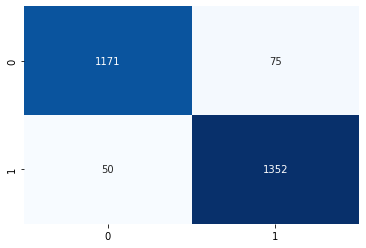

Model  1 
 Accuracy :  0.9936858721389108
 Precision :  0.9962121248245239
 Recall :  0.99370276927948
 F1 score :  0.994955837726593
Confusion matrix : 


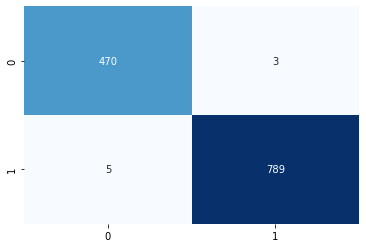

Model  2 
 Accuracy :  0.9573435504469987
 Precision :  0.9599459767341614
 Recall :  0.9647218585014343
 F1 score :  0.9623280167579651
Confusion matrix : 


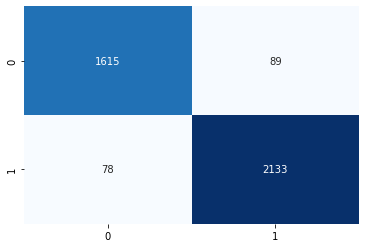

In [21]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", i, "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.show()

In [22]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist[i][0][0].weight.data.numpy() for i in range(3)]

In [23]:
print(weights[0].shape)
print(weights[0])

(2, 512)
[[ 0.8541221   0.26583007 -0.2700813  ...  0.4216159   0.58827406
  -0.03928456]
 [-0.87368    -0.298936    0.23054606 ... -0.42329523 -0.6505777
   0.03748782]]


In [24]:
# store the weights in a pandas dataframe
weights_df = pd.DataFrame(weights[0], columns=X_gd_N_train.columns)
weights_df['dataset'] = 'N'
weights_df = weights_df.append(pd.DataFrame(weights[1], columns=X_gd_A_train.columns))
weights_df['dataset'] = weights_df['dataset'].fillna('A')
weights_df = weights_df.append(pd.DataFrame(weights[2], columns=X_gd_both_train.columns))
weights_df['dataset'] = weights_df['dataset'].fillna('both')

# set the dataset as index
weights_df = weights_df.set_index('dataset')

In [25]:
weights_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
dataset,,,,,,,,,,,,,,,,,,,,,
N,0.854122,0.265830,-0.270081,-0.124365,0.787919,-1.159059,-0.230776,-1.651336,0.876306,0.410869,...,-0.205661,0.884320,-0.110036,0.551669,0.120064,-1.499025,-0.475892,0.421616,0.588274,-0.039285
N,-0.873680,-0.298936,0.230546,0.149317,-0.823480,1.130722,0.243460,1.598969,-0.853738,-0.389886,...,0.233566,-0.868311,0.176815,-0.519234,-0.111272,1.493482,0.507256,-0.423295,-0.650578,0.037488
A,0.638243,0.203143,-0.467871,-0.177651,0.441557,-1.288819,-0.328329,-0.690078,0.338080,0.382600,...,0.101394,0.992284,0.131838,0.301286,-0.543865,-1.015250,0.089568,0.206914,0.126260,0.517275
A,-0.557148,-0.245492,0.453703,0.194837,-0.441894,1.283389,0.302763,0.688311,-0.329016,-0.355484,...,-0.102149,-1.049878,-0.144221,-0.285903,0.526951,0.999123,-0.091815,-0.204219,-0.187008,-0.571953
both,1.191835,0.250017,-0.756421,0.008322,0.965847,-1.514096,-0.296678,-1.829767,1.084059,0.481348,...,-0.231771,1.227640,-0.106458,0.864913,-0.052629,-1.716936,-0.432560,0.612500,0.616408,-0.033330
both,-1.147944,-0.214942,0.787760,-0.004984,-0.963785,1.563147,0.356138,1.812294,-1.082689,-0.435424,...,0.163569,-1.200040,0.140668,-0.839621,0.058741,1.706712,0.490109,-0.601387,-0.620640,0.072079


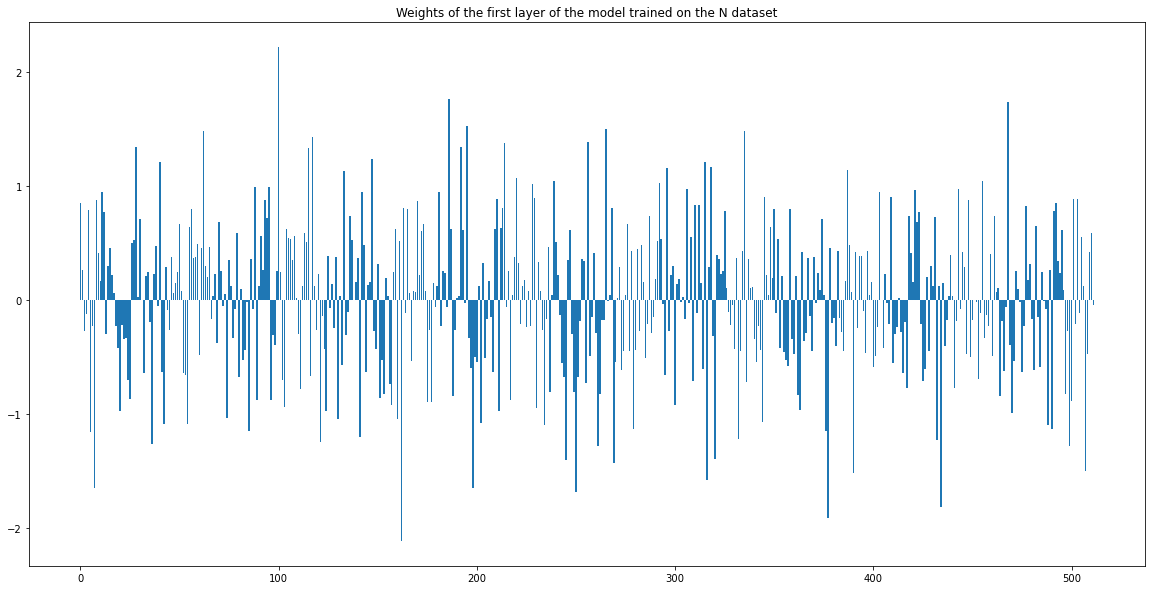

In [26]:
weights_N_0 = weights_df.iloc[0, :]
weights_N_0

# plot weights_N_0
plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_N_0.values)
plt.title('Weights of the first layer of the model trained on the N dataset')
plt.show()

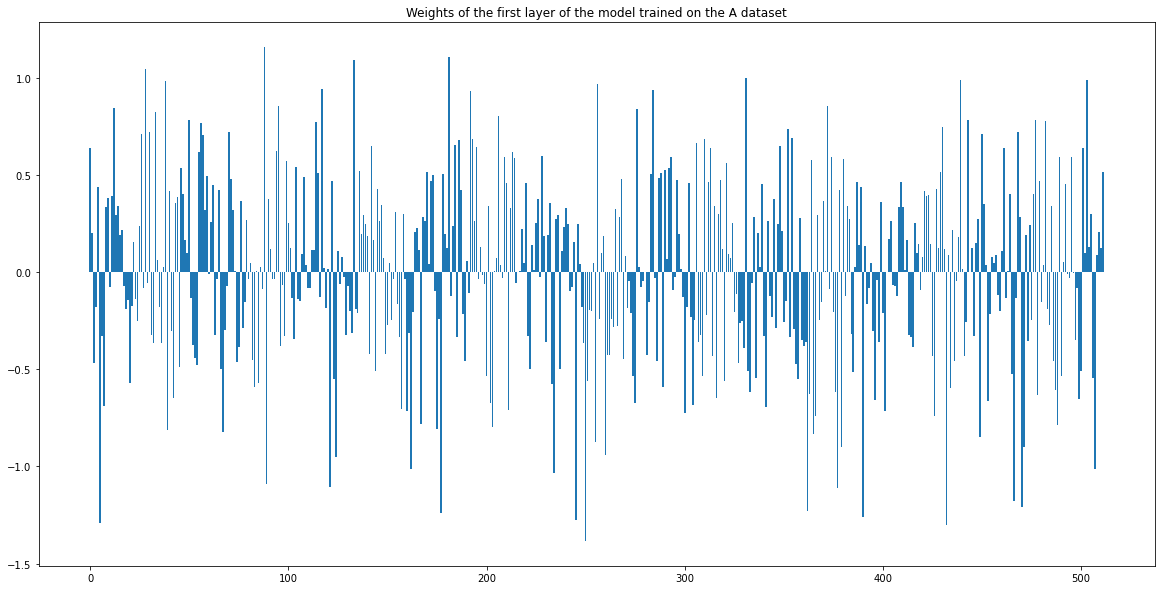

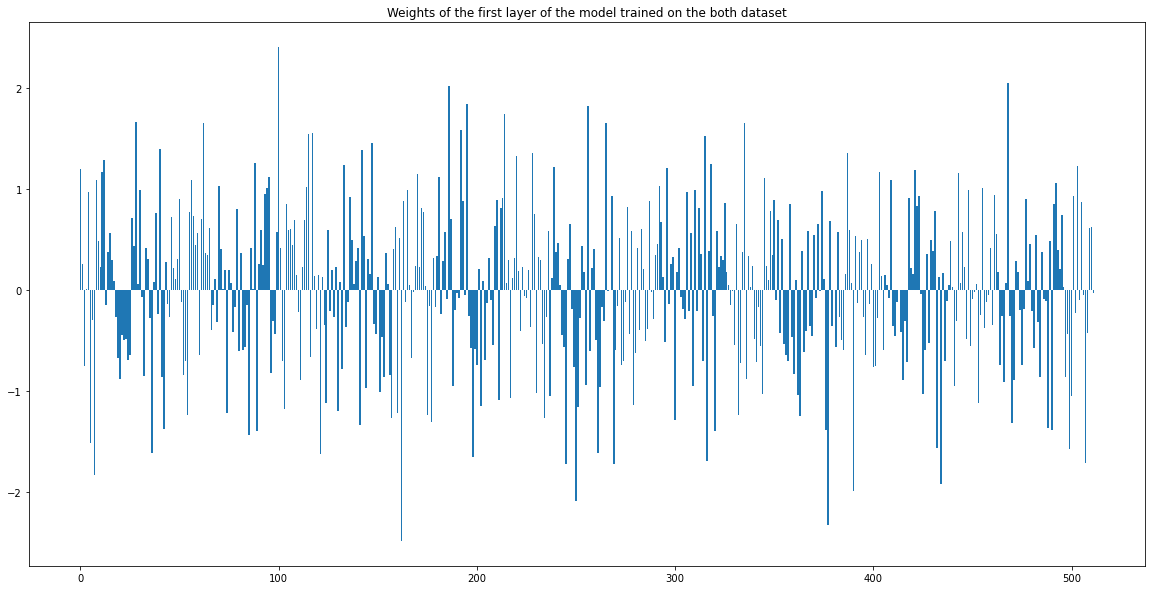

In [27]:
# do the same for the other datasets
weights_A_0 = weights_df.iloc[2, :]
weights_both_0 = weights_df.iloc[4, :]

plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_A_0.values)
plt.title('Weights of the first layer of the model trained on the A dataset')
plt.show()

plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_both_0.values)
plt.title('Weights of the first layer of the model trained on the both dataset')
plt.show()

In [28]:
sorted_features = []
for i in range(3):
    # get the list of weights ordered by decreasing absolute value
    to_sort = weights[i][0]
    to_sort = np.abs(to_sort)
    sorted = np.argsort(to_sort)[::-1]
    sorted_features.append(sorted)

In [29]:
for i in range(3):
    print("Model ", i, " : \n")
    for feat in sorted_features[i][:10]:
        print(f"{int(feat)}: {weights[i][0][int(feat)]}    {weights[i][1][int(feat)]}")

Model  0  : 

100: 2.2245984077453613    -2.234943389892578
162: -2.1165616512298584    2.085672616958618
377: -1.9108648300170898    1.8961654901504517
434: -1.8204941749572754    1.7863205671310425
186: 1.762897253036499    -1.793614149093628
468: 1.7402589321136475    -1.7979841232299805
250: -1.6821120977401733    1.6262961626052856
7: -1.6513360738754272    1.5989694595336914
198: -1.6483559608459473    1.618848443031311
316: -1.5771095752716064    1.5862444639205933
Model  1  : 

250: -1.384472370147705    1.4185564517974854
432: -1.3012604713439941    1.3056219816207886
5: -1.288819432258606    1.2833894491195679
245: -1.2772997617721558    1.277860164642334
390: -1.2612090110778809    1.2627521753311157
177: -1.238551139831543    1.2476054430007935
362: -1.2271100282669067    1.2185349464416504
470: -1.207877516746521    1.1948522329330444
466: -1.1798899173736572    1.1622649431228638
88: 1.1606709957122803    -1.156182885169983
Model  2  : 

162: -2.488166570663452    2.52621

# NN Classification (Perceptron) : Number

In [2]:
df_nouns_we = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv').drop(columns=["gender"])
df_adj_we = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv').drop(columns = "gender")
df_both_we = pd.concat([df_nouns_we, df_adj_we], ignore_index=True)
# target : number
Y_nb_N = df_nouns_we["number"].apply(lambda x: 1 if x == "singular" else 0)
Y_nb_A = df_adj_we["number"].apply(lambda x: 1 if x == "singular" else 0)
Y_nb_both = df_both_we["number"].apply(lambda x: 1 if x == "singular" else 0)
# features : word embeddings dimensions
X_nb_N = df_nouns_we.drop(columns=["Word", "number"])
X_nb_A = df_adj_we.drop(columns=["Word", "number"])
X_nb_both = df_both_we.drop(columns = ["Word", "number"] )

# normalize data to be between 0 and 1
X_nb_N = (X_nb_N - X_nb_N.min()) / (X_nb_N.max() - X_nb_N.min())
X_nb_A = (X_nb_A - X_nb_A.min()) / (X_nb_A.max() - X_nb_A.min())
X_nb_both = (X_nb_both - X_nb_both.min()) / (X_nb_both.max() - X_nb_both.min())


# split data into train and test sets
X_nb_N_train, X_nb_N_test, Y_nb_N_train, Y_nb_N_test = train_test_split(X_nb_N, Y_nb_N, test_size=0.2, random_state=42)
X_nb_A_train, X_nb_A_test, Y_nb_A_train, Y_nb_A_test = train_test_split(X_nb_A, Y_nb_A, test_size=0.2, random_state=42)
X_nb_both_train, X_nb_both_test, Y_nb_both_train, Y_nb_both_test = train_test_split(X_nb_both, Y_nb_both, test_size=0.2, random_state=42)

In [3]:
# print all the shapes
print("X_nb_N_train shape : ", X_nb_N_train.shape)
print("X_nb_N_test shape : ", X_nb_N_test.shape)
print("Y_nb_N_train shape : ", Y_nb_N_train.shape)
print("Y_nb_N_test shape : ", Y_nb_N_test.shape)
print("X_nb_A_train shape : ", X_nb_A_train.shape)
print("X_nb_A_test shape : ", X_nb_A_test.shape)
print("Y_nb_A_train shape : ", Y_nb_A_train.shape)
print("Y_nb_A_test shape : ", Y_nb_A_test.shape)
print("X_nb_both_train shape : ", X_nb_both_train.shape)
print("X_nb_both_test shape : ", X_nb_both_test.shape)

X_nb_N_train shape :  (10590, 512)
X_nb_N_test shape :  (2648, 512)
Y_nb_N_train shape :  (10590,)
Y_nb_N_test shape :  (2648,)
X_nb_A_train shape :  (5067, 512)
X_nb_A_test shape :  (1267, 512)
Y_nb_A_train shape :  (5067,)
Y_nb_A_test shape :  (1267,)
X_nb_both_train shape :  (15657, 512)
X_nb_both_test shape :  (3915, 512)


In [4]:
train_feature = [X_nb_N_train, X_nb_A_train, X_nb_both_train]
test_feature = [X_nb_N_test, X_nb_A_test, X_nb_both_test]
train_target = [Y_nb_N_train, Y_nb_A_train, Y_nb_both_train]
test_target = [Y_nb_N_test, Y_nb_A_test, Y_nb_both_test]

### Tensors

In [5]:
# convert to tensors
train_feature = [torch.tensor(x.values).float() for x in train_feature]
test_feature = [torch.tensor(x.values).float() for x in test_feature]
train_target = [torch.tensor(x.values).long() for x in train_target]
test_target = [torch.tensor(x.values).long() for x in test_target]

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_feature, train_target)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_feature, test_target)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

## Classification

In [9]:
NNlist = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer (2 classes)
    model = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist.append([model, loss_fn, optimizer])

## Train the models

In [10]:
nb_epochs = 100
# train the models 
for i in range(3):
    print("* Training model ", i)
    model, loss_fn, optimizer = NNlist[i]
    # put the model in training mode
    model.train()
    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  0
--Epoch  0  Loss :  0.5440499186515808
--Epoch  10  Loss :  0.3528536856174469
--Epoch  20  Loss :  0.3297676742076874
--Epoch  30  Loss :  0.33709916472435
--Epoch  40  Loss :  0.3687392473220825
--Epoch  50  Loss :  0.3336738049983978
--Epoch  60  Loss :  0.31871163845062256
--Epoch  70  Loss :  0.3264993131160736
--Epoch  80  Loss :  0.32264789938926697
--Epoch  90  Loss :  0.31724223494529724
* Training model  1
--Epoch  0  Loss :  0.598804235458374
--Epoch  10  Loss :  0.3743787705898285
--Epoch  20  Loss :  0.4013937711715698
--Epoch  30  Loss :  0.3459959328174591
--Epoch  40  Loss :  0.33310461044311523
--Epoch  50  Loss :  0.3210395574569702
--Epoch  60  Loss :  0.3290303349494934
--Epoch  70  Loss :  0.3172324001789093
--Epoch  80  Loss :  0.3195200562477112
--Epoch  90  Loss :  0.32089078426361084
* Training model  2
--Epoch  0  Loss :  0.4789024591445923
--Epoch  10  Loss :  0.3276904821395874
--Epoch  20  Loss :  0.32392215728759766
--Epoch  30  Loss : 

Model  0 
 Accuracy :  0.9928247734138973
 Precision :  0.9953703880310059
 Recall :  0.9936453104019165
 F1 score :  0.9945071339607239
Confusion matrix : 


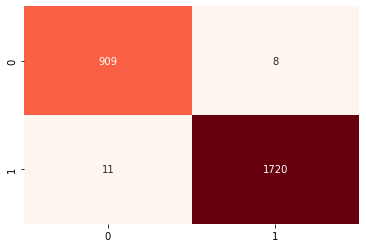

Model  1 
 Accuracy :  0.994475138121547
 Precision :  0.9962406158447266
 Recall :  0.9949937462806702
 F1 score :  0.9956168532371521
Confusion matrix : 


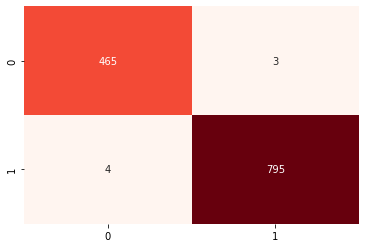

Model  2 
 Accuracy :  0.9936143039591315
 Precision :  0.9936733841896057
 Recall :  0.9964314103126526
 F1 score :  0.9950504899024963
Confusion matrix : 


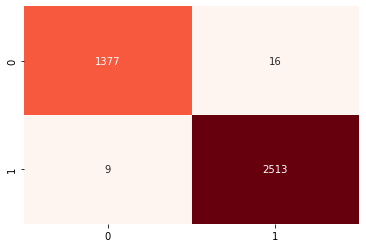

In [11]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", i, "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Reds', cbar=False)
    plt.show()

In [12]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist[i][0][0].weight.data.numpy() for i in range(3)]
print(weights[0].shape)
print(weights[0])

(2, 512)
[[-0.05428017  0.8474955  -0.2600719  ... -0.07665038 -0.49273592
   0.6974068 ]
 [ 0.09440201 -0.86792743  0.23487496 ...  0.13763265  0.4493265
  -0.70801145]]


In [13]:
# store the weights in a pandas dataframe
weight_df = pd.DataFrame(weights[0], columns=X_nb_N_train.columns)
weight_df['dataset'] = 'N'
weight_df = weight_df.append(pd.DataFrame(weights[1], columns=X_nb_A_train.columns))
weight_df['dataset'] = weight_df['dataset'].fillna('A')
weight_df = weight_df.append(pd.DataFrame(weights[2], columns=X_nb_both_train.columns))
weight_df['dataset'] = weight_df['dataset'].fillna('both')

# set the dataset as index
weight_df = weight_df.set_index('dataset')

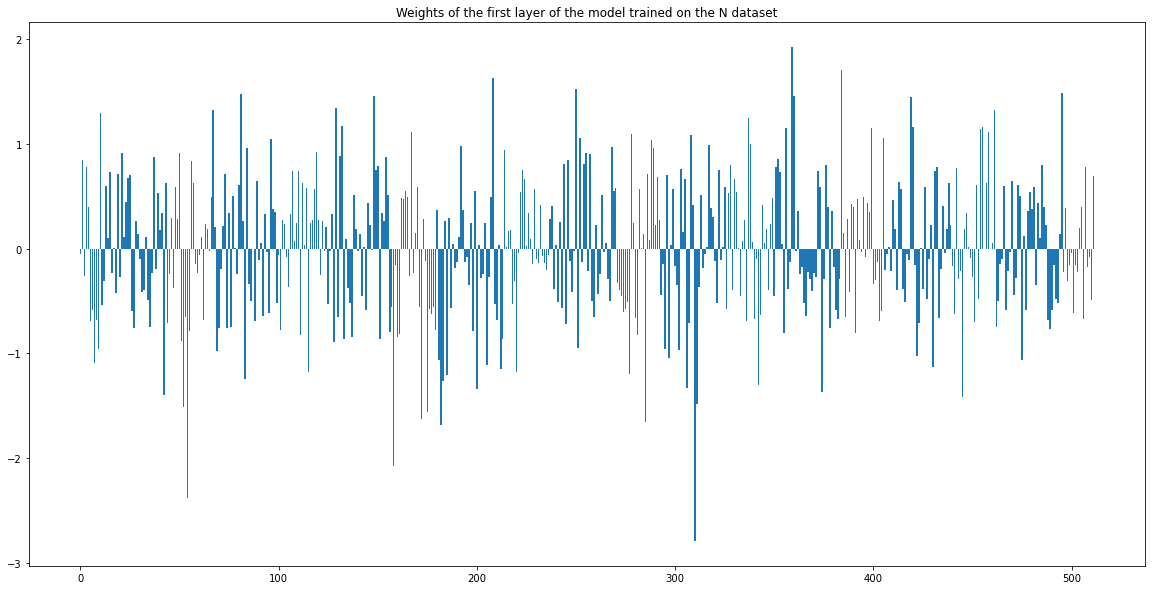

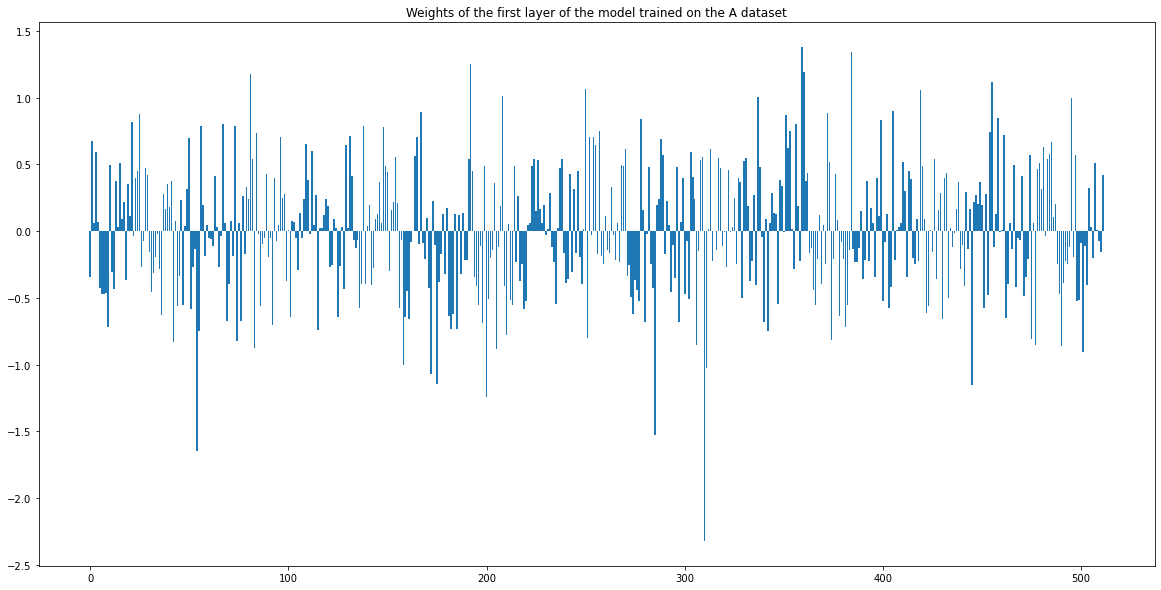

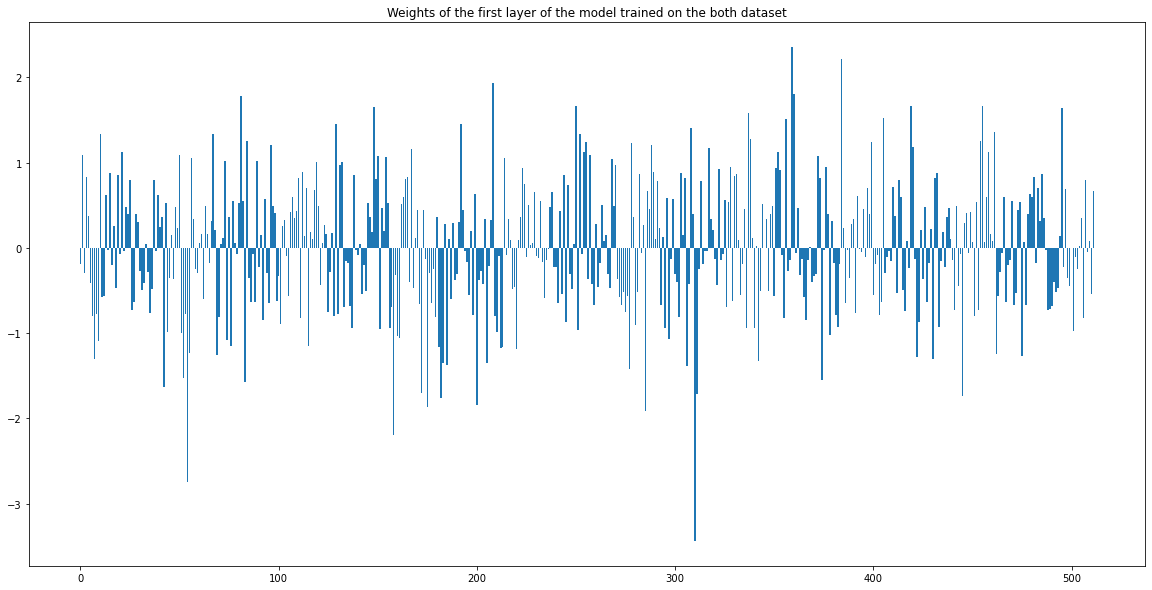

In [14]:
weight_N_0 = weight_df.iloc[0, :]
weight_N_0

# plot weights_N_0
plt.figure(figsize=(20, 10))
plt.bar(range(512), weight_N_0.values)
plt.title('Weights of the first layer of the model trained on the N dataset')
plt.show()

# do the same for the other datasets
weight_A_0 = weight_df.iloc[2, :]
weight_both_0 = weight_df.iloc[4, :]

plt.figure(figsize=(20, 10))
plt.bar(range(512), weight_A_0.values)
plt.title('Weights of the first layer of the model trained on the A dataset')
plt.show()

plt.figure(figsize=(20, 10))
plt.bar(range(512), weight_both_0.values)
plt.title('Weights of the first layer of the model trained on the both dataset')
plt.show()

In [15]:
sorted_feature = []
for i in range(3):
    # get the list of weights ordered by decreasing absolute value
    to_sort = weights[i][0]
    to_sort = np.abs(to_sort)
    sorted = np.argsort(to_sort)[::-1]
    sorted_feature.append(sorted)
for i in range(3):
    print("Model ", i, " : \n")
    for feat in sorted_feature[i][:10]:
        print(f"{int(feat)}: {weights[i][0][int(feat)]}    {weights[i][1][int(feat)]}")

Model  0  : 

310: -2.792752742767334    2.752384901046753
54: -2.3840601444244385    2.3914434909820557
158: -2.075476884841919    2.098706007003784
359: 1.9256991147994995    -1.951188564300537
384: 1.7078708410263062    -1.7339001893997192
182: -1.6865204572677612    1.6483664512634277
285: -1.6589934825897217    1.6918779611587524
208: 1.627899408340454    -1.6493594646453857
172: -1.6249306201934814    1.5960391759872437
175: -1.5643868446350098    1.5959937572479248
Model  1  : 

310: -2.321359634399414    2.2920455932617188
54: -1.647988200187683    1.6482157707214355
285: -1.5242090225219727    1.4959254264831543
359: 1.3792327642440796    -1.4213255643844604
384: 1.338271141052246    -1.3034344911575317
192: 1.252180814743042    -1.2543212175369263
200: -1.239863634109497    1.1974321603775024
360: 1.1877422332763672    -1.2232239246368408
81: 1.1762264966964722    -1.2452976703643799
445: -1.1541365385055542    1.0912978649139404
Model  2  : 

310: -3.4401397705078125    3.41